From https://github.com/bentrevett/pytorch-seq2seq

# 3 - Neural Machine Translation by Jointly Learning to Align and Translate

*This notebook is based on [open-source implementation](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb) of seq2seq NMT with attention in PyTorch.*



In this third notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). 

## Introduction

As a reminder, here is the general encoder-decoder model:

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/master/assets/seq2seq1.png)

In the previous model, our architecture was set-up in a way to reduce "information compression" by explicitly passing the context vector, $z$, to the decoder at every time-step and by passing both the context vector and embedded input word, $d(y_t)$, along with the hidden state, $s_t$, to the linear layer, $f$, to make a prediction.

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/master/assets/seq2seq7.png)

Even though we have reduced some of this compression, our context vector still needs to contain all of the information about the source sentence. The model implemented in this notebook avoids this compression by allowing the decoder to look at the entire source sentence (via its hidden states) at each decoding step! How does it do this? It uses *attention*. 

Attention works by first, calculating an attention vector, $a$, that is the length of the source sentence. The attention vector has the property that each element is between 0 and 1, and the entire vector sums to 1. We then calculate a weighted sum of our source sentence hidden states, $H$, to get a weighted source vector, $w$. 

$$w = \sum_{i}a_ih_i$$

We calculate a new weighted source vector every time-step when decoding, using it as input to our decoder RNN as well as the linear layer to make a prediction. We'll explain how to do all of this during the tutorial.

## Preparing Data

Again, the preparation is similar to last time.

First we import all the required modules.

In [3]:
#!python -m pip install torchtext==0.4.0

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

Set the random seeds for reproducability.

In [5]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Load the German and English spaCy models.

In [6]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer):
    """Lower sentence and then return the list of tokens"""
    return tokenizer.tokenize(x.lower())

In [7]:
# ! python -m spacy download en
# ! python -m spacy download de
trg = Field(
            lower = True,
            init_token="<sos>",
            eos_token="<eos>",
            tokenize=tokenize,
            pad_token='<pad>',
            unk_token='<unk>',
           )

src = Field(
            lower = True,
            init_token="<sos>",
            eos_token="<eos>",
            tokenize=tokenize,
            pad_token='<pad>',
            unk_token='<unk>',
           )


train_data, valid_data, test_data = Multi30k.splits(
    exts=('.de', '.en'),
    fields = (src, trg)
)


trg.build_vocab(train_data, min_freq=3)
src.build_vocab(train_data, min_freq=3)


print(f"Number of training examples: {len(train_data)}")
print(vars(train_data.examples[0]))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 611kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 173kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 167kB/s]


Number of training examples: 29000
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


In [8]:
# spacy_de = spacy.load('de')
# spacy_en = spacy.load('en')
src_vocab = src.vocab.stoi
trg_vocab = trg.vocab.stoi

We create the tokenizers.

In [9]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

The fields remain the same as before.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Create the iterators.

In [11]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

In [12]:
for batch in train_iterator:
    (x, y), _ = batch
    break
print(x.shape)
print(y.shape)

torch.Size([23, 128])
torch.Size([23, 128])


## Building the Seq2Seq Model

### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. With a bidirectional RNN, we have two RNNs in each layer. A *forward RNN* going over the embedded sentence from left to right (shown below in green), and a *backward RNN* going over the embedded sentence from right to left (teal). All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before. 

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/master/assets/seq2seq8.png)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

As before, we only pass an input (`embedded`) to the RNN, which tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros. We'll also get two context vectors, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`. 

`outputs` is of size **[src len, batch size, hid dim * num directions]** where the first `hid_dim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hid_dim` elements are hidden states from the top layer backward RNN. We can think of the third axis as being the forward and backward hidden states concatenated together other, i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]**, where **[-2, :, :]** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence) and **[-1, :, :]** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).

As the decoder is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$, and we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function. 

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so we have changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)   
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)   
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inp):
        
        #src = [src_len, batch_size] 
        embedded = self.dropout(self.embedding(inp))
        
        #embedded = [src len, batch size, emb dim]        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src_len, batch_size, hid_dim * num_directions]
        #hidden = [n_layers * num directions, batch_size, hid_dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src_len, batch_size, enc_hid_dim * 2] - concat hid vector for every token
        #hidden = [batch_size, dec_hid_dim] - changed with fc hidden state from last step 
        
        return outputs, hidden

In [14]:
x.shape

torch.Size([23, 128])

In [17]:
test_enc = Encoder(input_dim = len(src_vocab), emb_dim=256, enc_hid_dim=256, dec_hid_dim=256, dropout=0.2)
test_enc_out = test_enc(x.to("cpu"))
test_enc_out[0].shape, test_enc_out[1].shape

(torch.Size([23, 128, 512]), torch.Size([128, 256]))

### Attention

Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src len]** tensor for each example in the batch. We want this to be **[src len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of $v$ as the weights for a weighted sum of the energy across all encoder hidden states. These weights tell us how much we should attend to each token in the source sequence. The parameters of $v$ are initialized randomly, but learned with the rest of the model via backpropagation. Note how $v$ is not dependent on time, and the same $v$ is used for each time-step of the decoding. We implement $v$ as a linear layer without a bias.

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/teal blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/master/assets/seq2seq9.png)

In [18]:
test_hidden = torch.rand((128, 256))
test_hidden.unsqueeze(1).repeat(1, 28, 1).shape

torch.Size([128, 28, 256])

In [19]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch_size, dec_hid_dim] - hidden state from previous state of decoder
        #encoder_outputs = [src_len, batch_size, enc_hid_dim * 2] - all hidden states from encoder
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #hidden = [batch_size, src_len, dec_hid_dim]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch_size, src_len, enc_hid_dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch_size, src_len, dec_hid_dim]

        attention = self.v(energy).squeeze(2)     
        #attention= [batch_size, src_len]
        
        return F.softmax(attention, dim=1)

In [20]:
test_hidden = torch.rand((4, 256))
test_encoder_outputs = torch.rand((28, 4, 256*2))

test_attention = Attention(256, 256)
test_attention(test_hidden, test_encoder_outputs).sum(axis=1) # softmax layer output 

tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/master/assets/seq2seq10.png)

The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [21]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch_size, dec_hid_dim]
        #encoder_outputs = [src_len, batch_size, enc_hid_dim * 2]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch_size, emb_dim]
        
        a = self.attention(hidden, encoder_outputs)             
        #a = [batch_size, src_len]
        
        a = a.unsqueeze(1)
        #a = [batch_size, 1, src_len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  
        #encoder_outputs = [batch_size, src_len, enc_hid_dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)   
        #weighted = [batch_size, 1, enc_hid_dim * 2]
        
        weighted = weighted.permute(1, 0, 2)     
        #weighted = [1, batch_size, enc_hid_dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2) 
        #rnn_input = [1, batch_size, (enc_hid_dim * 2) + emb_dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq_len, n_layers and n_directions will always be 1 in this decoder, therefore:
        #output = [1, batch_size, dec_hid_dim]
        #hidden = [1, batch_size, dec_hid_dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

### Seq2Seq

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [22]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one.

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [87]:
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.35
DEC_DROPOUT = 0.35

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [88]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(18606, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.35, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(10075, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=10075, bias=True)
    (dropout): Dropout(p=0.35, inplace=False)
  )
)

Calculate the number of parameters. We get an increase of almost 50% in the amount of parameters from the last model. 

In [89]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 31,840,091 trainable parameters


We create an optimizer.

In [90]:
optimizer = optim.Adam(model.parameters(), lr = 0.00085)

We initialize the loss function.

In [91]:
TRG_PAD_IDX = trg.vocab.stoi[trg.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

We then create the training loop...

In [92]:
PLOT_STEP = 0

In [93]:
def train(model, iterator, optimizer, criterion, 
          clip, train_history=None, valid_history=None, 
          plot_local=True):
    
    global PLOT_STEP
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src_batch = batch.src
        trg_batch = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src_batch, trg_batch)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg_batch = trg_batch[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg_batch)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            PLOT_STEP += i
            # if writer is not None:
                # writer.add_scalar('train loss', history[-1], PLOT_STEP)
            
            if plot_local:
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

                clear_output(True)
                ax[0].plot(history, label='train loss')
                ax[0].set_xlabel('Batch')
                ax[0].set_title('Train loss')
                ax[0].grid()
                if train_history is not None:
                    ax[1].plot(train_history, label='general train history')
                    ax[1].set_xlabel('Epoch')
                if valid_history is not None:
                    ax[1].plot(valid_history, label='general valid history')
                ax[1].grid()
                plt.legend()

                plt.show()

        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [94]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src_batch = batch.src
            trg_batch = batch.trg

            output = model(src_batch, trg_batch, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg_batch = trg_batch[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg_batch)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Finally, define a timing function.

In [95]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [96]:
import numpy as np
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [97]:
example_input = next(iter(train_iterator))

In [98]:
example_input.src.shape

torch.Size([31, 128])

In [ ]:
# from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we can be more specific here
# writer = SummaryWriter()

In [ ]:
# writer.add_graph(model, (example_input.src[:1], example_input.trg[:1]))
# writer.close()

In [99]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        tokens = tokenize(sentence)
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for t in range(1, max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        #insert input token embedding, previous hidden state and all encoder hidden states
        #receive output tensor (predictions) and new hidden state
        output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)

        pred_token = output.argmax(1).item() 
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:]

In [100]:
def get_example_translation():
    example_idx = np.random.choice(np.arange(len(test_data)))
    src_sentence = test_data.examples[example_idx].src
    trg_sentence = test_data.examples[example_idx].trg
    
    src_string = f'src = {" ".join(src_sentence)}'
    trg_string = f'trg = {" ".join(trg_sentence)}'

    translation = translate_sentence(src_sentence, src, trg, model, device)
    
    translation_string = f'pred = {" ".join(translation)}'

#     print(src_string)
#     print()
#     print(trg_string)
#     print()
#     print(translation_string)
    
    return ('\n'.join([src_string, trg_string, translation_string]))

Let's call the `tensorboard` here (if you are working on Colab). If you work locally better run it as another process in your terminal using the command
```
tensorboard --logdir .runs/ --reload_interval=5
```

In [ ]:
# On Colab just uncomment and run this cell

# %load_ext tensorboard
# %tensorboard --logdir runs

Finally, we train our model, saving the parameters that give us the best validation loss.

In [101]:
train_history = []
valid_history = []

N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

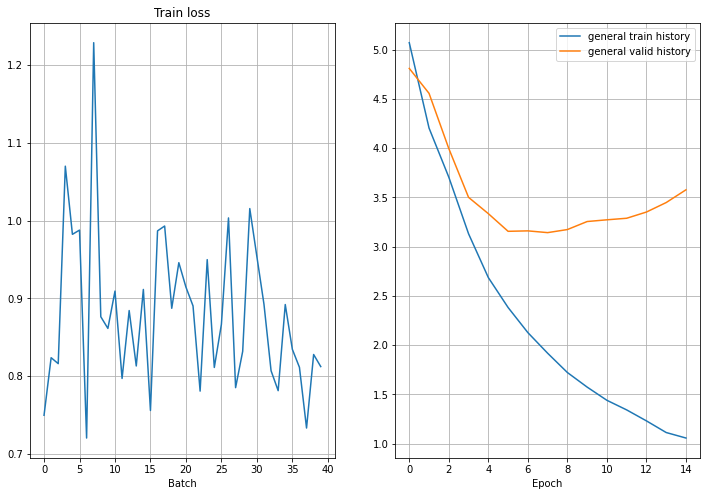

KeyboardInterrupt: 

In [102]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, 
                       train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    # writer.add_scalar('mean train loss per epoch', train_loss, global_step=epoch)
    # writer.add_scalar('mean val loss per epoch', valid_loss, global_step=epoch)

    val_example_data = next(iter(valid_iterator))
    to_print = []
    
    
    # writer.add_text('translation example', get_example_translation(), global_step=epoch)
    # writer.close()

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Finally, we test the model on the test set using these "best" parameters.

In [103]:
model.load_state_dict(torch.load('/kaggle/working/tut1-model.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.128 | Test PPL:  22.817 |


In [105]:
for _ in range(20):
    print(get_example_translation())
    print()

src = zwei männer in badehosen springen auf einem mäßig belebten strand in die luft .
trg = two men wearing swim trunks jump in the air at a moderately populated beach .
pred = two men in bathing suits jumping on a beach in a beach . <eos>

src = eine frau isst an einem schönen tag auf dem gras .
trg = a woman eating in the grass on a beautiful day .
pred = a woman is on the on on the on on a beautiful day day . <eos>

src = ein mann in uniform und ein mann in einem blauen hemd stehen vor einem wagen .
trg = a man in uniform and a man in a blue shirt are standing in front of a truck .
pred = a man in uniform and a man in a blue shirt are standing in front of a cart . <eos>

src = ein typ in einem weißen hemd spielt auf einer weißen gitarre .
trg = a guy wearing a white shirt is playing a white guitar .
pred = a guy in a white shirt is playing a white guitar . <eos>

src = eine frau spielt volleyball .
trg = a woman is playing volleyball .
pred = a woman playing volleyball playing volle

We've improved on the previous model, but this came at the cost of doubling the training time.

In the next notebook, we'll be using the same architecture but using a few tricks that are applicable to all RNN architectures - packed padded sequences and masking. We'll also implement code which will allow us to look at what words in the input the RNN is paying attention to when decoding the output.